# Question 3: Trajectory Evaluation and g2o

_Refer to the example notebooks for installation instructions_

# Evo

So you've implemented 2D SLAM, great! Now, what? We need a measure of how good the trajectory is. The error/loss used earlier doesn't tell us much about how the trajectory differs from the ground truth. Here, we try to do just this - compute error metrics. Rather than computing these from scratch, we will just Evo - https://github.com/MichaelGrupp/evo/.

Look at the absolute pose error (APE) and relative pose error (RPE). What do they capture and how are they calculated (descriptive answer)? How do these metrics differ in methodology? Can we determine if the error is more along the x/y axis?

Answer the above questions and report errors for the obtained trajectory.

In [19]:
#! pip install evo --upgrade --no-binary evo

! cp '../data/gt.txt' '../results/gt.g2o'
! python3 '../misc/g2o_to_kitti.py' '../results/gt.g2o' '../results/gt.kitti'
! python3 '../misc/g2o_to_kitti.py' '../results/opt-poses.g2o' '../results/opt-poses.kitti'

! evo_ape kitti ../results/gt.kitti ../results/opt-poses.kitti
! evo_rpe kitti ../results/gt.kitti ../results/opt-poses.kitti
! evo_traj kitti ../results/gt.kitti ../results/opt-poses.kitti -v --plot --plot_mode xy

Figure(640x480)
saved '../results/gt.kitti' from '../results/gt.g2o'
Figure(640x480)
saved '../results/opt-poses.kitti' from '../results/opt-poses.g2o'
APE w.r.t. translation part (m)
(not aligned)

       max	13.099711
      mean	9.448621
    median	11.783399
       min	0.434456
      rmse	10.191792
       sse	12464.714187
       std	3.820494

RPE w.r.t. translation part (m)
for delta = 1 (frames) using consecutive pairs
(not aligned)

       max	3.030493
      mean	0.770000
    median	0.631140
       min	0.025292
      rmse	0.949114
       sse	107.197370
       std	0.554903

--------------------------------------------------------------------------------
Loaded 120 poses from: ../results/gt.kitti
Loaded 120 poses from: ../results/opt-poses.kitti
--------------------------------------------------------------------------------
name:	gt
infos:
	nr. of poses	120
	path length (m)	52.976517997999295
	pos_end (m)	[-2.8 -4.5  0. ]
	pos_start (m)	[-8.  5.  0.]
--------------------------------

## Theory

### APE
APE (Absolute Pose Error) is a metric for determining the global consistency of a SLAM trajectory.

Computation: 

It returns the difference between the estimated trajectory points and the ground-truth trajectory points.

Translation Part - This uses the translation part of $E_i$: <br />
$ APE_i = \| \mathrm{trans}(E_i) \| $ <br />
This is equivalent to the point distance between the pose pairs points.

It is easy to compare as it returns a single number but is sensitive to the time when the error is estimated, i.e, it is generally higher for initial iterations and lower for consequent iterations.
 
### RPE
RPE (Relative Pose Error) is a metric for determining the local consistency of a SLAM trajectory although it can also be sort of extended for the global case.

Computation:  
1. Select all sub-trajectories of length d.
2. Align each sub-trajectory using the respective 1st states.
3. Determine the error of each sub-end trajectory's state. For each sub-trajectory, a relative error is calculated in a similar way as the absolute error.
4. Can take the average, median, etc. of the above errors to obtain a single error value.

The relative error can be used for both, short and long term accuracy, by varying the length d of the selected sub-trajectories. Another advantage is that by selecting the states according to different criteria, RPE can have different meanings. For example, a common practice is to select pairs of states that are spaced by a certain distance along the trajectory. The issue with RPE is that calculations are relatively difficult and expensive and ranking/understanding the estimation accuracy is harder.

We can identify whether the error is larger along the x/y axis by independently calculating the APE/RPE of the trajectory acquired by extending the project along the x/y axis and comparing the results.

If you're interested, play around with this tool and add any other plots that you think might be relevant/interesting.

# g2o

Install g2o as mentioned in `examples/g2o.ipynb` and optimise `edges.txt`, the file you used earlier. Also use `g2o_viewer` and optimize `intel` (a trajectory in the Intel research lab) and `sphere`. They should look something like:


<table><tr>
<td> <img src="../misc/intel.jpg" alt="Drawing" style="width: 250px;"/> </td>
<td> <img src="../misc/sphere.jpg" alt="Drawing" style="width: 250px;"/> </td>
</tr></table>

Write briefly about your observations and try out few options in the GUI. What do they do, how do they perform?

In [8]:
!cp ../data/edges.txt ../data/edges.g2o
!g2o -o ../results/opt-g2o.g2o ../data/edges.g2o
!g2o -o ../results/opt-intel.g2o ../data/intel.g2o
!g2o -o ../results/opt-sphere.g2o ../data/sphere.g2o

# Using EigenSparseCholesky poseDim -1 landMarkDim -1 blockordering 1
Read input from ../data/edges.g2o
virtual bool g2o::OptimizableGraph::load(std::istream&): Unable to find vertices for edge EDGE_SE2 at line 2 IDs:  0 <-> 1
virtual bool g2o::OptimizableGraph::load(std::istream&): Unable to find vertices for edge EDGE_SE2 at line 3 IDs:  1 <-> 2
virtual bool g2o::OptimizableGraph::load(std::istream&): Unable to find vertices for edge EDGE_SE2 at line 4 IDs:  2 <-> 3
virtual bool g2o::OptimizableGraph::load(std::istream&): Unable to find vertices for edge EDGE_SE2 at line 5 IDs:  3 <-> 4
virtual bool g2o::OptimizableGraph::load(std::istream&): Unable to find vertices for edge EDGE_SE2 at line 6 IDs:  4 <-> 5
virtual bool g2o::OptimizableGraph::load(std::istream&): Unable to find vertices for edge EDGE_SE2 at line 7 IDs:  5 <-> 6
virtual bool g2o::OptimizableGraph::load(std::istream&): Unable to find vertices for edge EDGE_SE2 at line 8 IDs:  6 <-> 7
virtual bool g2o::OptimizableGraph:

# Using EigenSparseCholesky poseDim -1 landMarkDim -1 blockordering 1
Read input from ../data/intel.g2o
Loaded 1228 vertices
Loaded 1483 edges
# graph is fixed by node 1227
Initial chi2 = 5149721.044789
saving ../results/opt-intel.g2o ... done.
# Using EigenSparseCholesky poseDim -1 landMarkDim -1 blockordering 1
Read input from ../data/sphere.g2o
Loaded 2200 vertices
Loaded 8647 edges
# graph is fixed by node 2199
Initial chi2 = 176631217.870692
saving ../results/opt-sphere.g2o ... done.


In [17]:
def readVertex(fileName):
    f = open(fileName, 'r')
    A = f.readlines()
    f.close()

    i_arr = []
    x_arr = []
    y_arr = []
    theta_arr = []

    for line in A:
        if "VERTEX_SE2" in line:
            (ver, ind, x, y, theta) = line.split()
            i_arr.append(int(ind))
            x_arr.append(float(x))
            y_arr.append(float(y))
            theta_arr.append(float(theta.rstrip('\n')))

    return jnp.array([i_arr, x_arr, y_arr, theta_arr])

def draw(X, Y, THETA):
    ax = plt.subplot(111)
    ax.plot(X, Y, 'ro')
    ax.plot(X, Y, 'c-')

    for i in range(len(THETA)):
        x2 = 0.25*math.cos(THETA[i]) + X[i]
        y2 = 0.25*math.sin(THETA[i]) + Y[i]
        plt.plot([X[i], x2], [Y[i], y2], 'g->')
        
    plt.show()

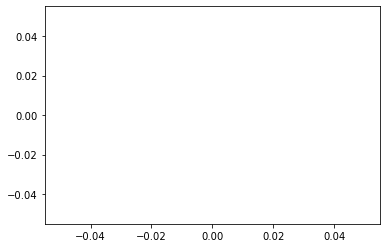

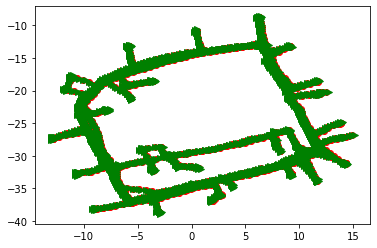

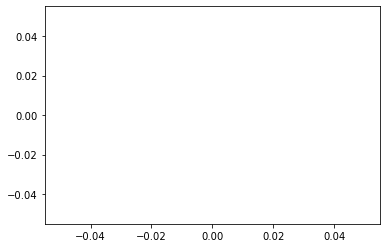

In [18]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import math

verts = np.array(readVertex('../results/opt-g2o.g2o'))
draw(verts[1, :], verts[2, :], verts[3, :])

Iverts = np.array(readVertex('../results/opt-intel.g2o'))
draw(Iverts[1, :], Iverts[2, :], Iverts[3, :])

Sverts = np.array(readVertex('../results/opt-sphere.g2o'))
draw(Sverts[1, :], Sverts[2, :], Sverts[3, :])